<a href="https://colab.research.google.com/github/moetzi/vrp-heuristics/blob/main/Greedy%2BGA_FP_Preskriptif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kelompok 12
* Mutiara Noor Fauzia NRP 5026221045
* I Gusti Ngurah Adhya Pradipta NRP 5026221184

# Import Library

In [ ]:
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 6.31.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.31.1 which is incom

In [ ]:
import numpy as np
import pandas as pd
import os
import random
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

# Import Dataset dan Preprocessing

In [ ]:
github_raw_url = "https://raw.githubusercontent.com/moetzi/vrp-heuristics/main/belgium-road-time-n50-k10.vrp"
local_filename = "belgium-road-time-n50-k10.vrp"

print(f"Mengunduh dataset dari: {github_raw_url}")
!wget {github_raw_url} -O {local_filename}

if os.path.exists(local_filename):
    print(f"Dataset '{local_filename}' berhasil diunduh.")
else:
    print(f"Gagal mengunduh dataset '{local_filename}'.")

Mengunduh dataset dari: https://raw.githubusercontent.com/moetzi/vrp-heuristics/main/belgium-road-time-n50-k10.vrp
--2025-06-20 04:21:56--  https://raw.githubusercontent.com/moetzi/vrp-heuristics/main/belgium-road-time-n50-k10.vrp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24958 (24K) [text/plain]
Saving to: ‘belgium-road-time-n50-k10.vrp’

belgium-road-time-n 100%[===================>]  24.37K  --.-KB/s    in 0.003s  

2025-06-20 04:21:56 (7.33 MB/s) - ‘belgium-road-time-n50-k10.vrp’ saved [24958/24958]

Dataset 'belgium-road-time-n50-k10.vrp' berhasil diunduh.


In [ ]:
def read_vrp_file(filename):

    with open(filename, 'r') as file:
        lines = file.readlines()

    data = {
        'name': '',
        'type': '',
        'dimension': 0,
        'edge_weight_type': '',
        'edge_weight_format': '',
        'edge_weight_unit': '',
        'capacity': 0,
        'node_coords_by_original_id': {},
        'demands_by_original_id': {},
        'depot_original_id': None,
        'time_matrix': []
    }

    current_section = None
    node_id_mapping = {}
    next_mapped_id = 0
    temp_edge_weights_lines = []

    for line in lines:
        line = line.strip()
        if not line:
            continue

        if line.startswith("NAME:"):
            data['name'] = line.split(":")[1].strip()
        elif line.startswith("TYPE:"):
            data['type'] = line.split(":")[1].strip()
        elif line.startswith("DIMENSION:"):
            data['dimension'] = int(line.split(":")[1].strip())
        elif line.startswith("EDGE_WEIGHT_TYPE:"):
            data['edge_weight_type'] = line.split(":")[1].strip()
        elif line.startswith("EDGE_WEIGHT_FORMAT:"):
            data['edge_weight_format'] = line.split(":")[1].strip()
        elif line.startswith("EDGE_WEIGHT_UNIT_OF_MEASUREMENT:"):
            data['edge_weight_unit'] = line.split(":")[1].strip()
        elif line.startswith("CAPACITY:"):
            data['capacity'] = int(line.split(":")[1].strip())

        elif "NODE_COORD_SECTION" in line:
            current_section = "NODE_COORD_SECTION"
            continue
        elif "DEMAND_SECTION" in line:
            current_section = "DEMAND_SECTION"
            continue
        elif "DEPOT_SECTION" in line:
            current_section = "DEPOT_SECTION"
            continue
        elif "EDGE_WEIGHT_SECTION" in line:
            current_section = "EDGE_WEIGHT_SECTION"
            continue
        elif "EOF" in line:
            break

        if current_section == "NODE_COORD_SECTION":
            parts = line.split()
            if len(parts) >= 3:
                try:
                    original_id = int(float(parts[0]))
                    lat = float(parts[1])
                    lon = float(parts[2])
                    data['node_coords_by_original_id'][original_id] = (lat, lon)
                    node_id_mapping[original_id] = next_mapped_id
                    next_mapped_id += 1
                except ValueError:
                    print(f"Format error (NODE_COORD_SECTION): {line}")

        elif current_section == "DEMAND_SECTION":
            parts = line.split()
            if len(parts) >= 2:
                try:
                    original_id = int(float(parts[0]))
                    demand = int(float(parts[1]))
                    data['demands_by_original_id'][original_id] = demand
                except ValueError:
                    print(f"Format error (DEMAND_SECTION): {line}")

        elif current_section == "DEPOT_SECTION":
            try:
                original_id = int(float(line.split()[0]))
                if original_id == -1:
                    current_section = None
                else:
                    data['depot_original_id'] = original_id
            except ValueError:
                print(f"Format error (DEPOT_SECTION): {line}")

        elif current_section == "EDGE_WEIGHT_SECTION":
            temp_edge_weights_lines.append(line)

    dimension = data['dimension']
    data['time_matrix'] = np.zeros((dimension, dimension))

    full_matrix_string = " ".join(temp_edge_weights_lines)
    all_weights = [float(w) for w in full_matrix_string.split()]

    k = 0
    for i in range(dimension):
        for j in range(dimension):
            data['time_matrix'][i, j] = all_weights[k]
            k += 1
            if k >= len(all_weights):
                break
        if k >= len(all_weights):
            break

    mapped_locations = [None] * dimension
    mapped_demands = [0] * dimension

    sorted_original_ids = sorted(node_id_mapping.keys(), key=lambda x: node_id_mapping[x])

    for original_id in sorted_original_ids:
        mapped_id = node_id_mapping[original_id]
        mapped_locations[mapped_id] = data['node_coords_by_original_id'][original_id]
        mapped_demands[mapped_id] = data['demands_by_original_id'].get(original_id, 0)

    data['locations'] = mapped_locations
    data['demands'] = mapped_demands
    data['depot_index'] = node_id_mapping.get(data['depot_original_id'])

    return data

In [ ]:
file_path = "belgium-road-time-n50-k10.vrp"
vrp_data = read_vrp_file(file_path)

print(f"Nama Dataset: {vrp_data['name']}")
print(f"Tipe Masalah: {vrp_data['type']}")
print(f"Total Dimensi (Node): {vrp_data['dimension']}")
print(f"Kapasitas Kendaraan: {vrp_data['capacity']}")
print(f"Unit Bobot Edge: {vrp_data['edge_weight_unit']}")
print(f"Indeks Depot (terpetakan): {vrp_data['depot_index']}")
print(f"Koordinat Depot: {vrp_data['locations'][vrp_data['depot_index']]}")

print(f"Demand Pelanggan ID 55 (Original ID): {vrp_data['demands_by_original_id'][55]}")

print(f"Demand Pelanggan (Indeks Terpetakan 1): {vrp_data['demands'][1]}")

print(f"Waktu tempuh dari Depot (idx 0) ke pelanggan 55 (Original ID, idx 1): {vrp_data['time_matrix'][0][1]} detik")

print("\nSebagian Matriks Waktu (5x5 pertama):")
print(vrp_data['time_matrix'][:5, :5])

Nama Dataset: belgium-road-time-n50-k10
Tipe Masalah: CVRP
Total Dimensi (Node): 50
Kapasitas Kendaraan: 125
Unit Bobot Edge: sec
Indeks Depot (terpetakan): 0
Koordinat Depot: (50.8427501, 4.3515499)
Demand Pelanggan ID 55 (Original ID): 15
Demand Pelanggan (Indeks Terpetakan 1): 15
Waktu tempuh dari Depot (idx 0) ke pelanggan 55 (Original ID, idx 1): 5194.095 detik

Sebagian Matriks Waktu (5x5 pertama):
[[   0.    5194.095 4508.267 3686.259 3860.893]
 [5090.662    0.    3481.919 8228.263 6269.092]
 [4446.509 3475.836    0.    7711.021 4706.544]
 [3673.741 8356.473 7774.428    0.    5146.348]
 [3833.977 6228.651 4711.105 5108.773    0.   ]]


In [ ]:
time_matrix = vrp_data['time_matrix']

original_ids_sorted = sorted(vrp_data['node_coords_by_original_id'].keys())

time_df = pd.DataFrame(time_matrix, index=original_ids_sorted, columns=original_ids_sorted)

print("Matriks Waktu (dalam detik, 5x5 pertama):")
print(time_df.head())
print("\nUkuran Matriks Waktu:", time_matrix.shape) # Menampilkan dimensi matriks numpy

Matriks Waktu (dalam detik, 5x5 pertama):
         0         55        110       165       220       275       330   \
0       0.000  5194.095  4508.267  3686.259  3860.893  3181.495  5469.861   
55   5090.662     0.000  3481.919  8228.263  6269.092  2390.205  5987.369   
110  4446.509  3475.836     0.000  7711.021  4706.544  3912.784  4213.595   
165  3673.741  8356.473  7774.428     0.000  5146.348  6343.873  6915.526   
220  3833.977  6228.651  4711.105  5108.773     0.000  5249.572  2449.610   

         385       440       495   ...      2200      2255      2310  \
0    5372.888  2987.367  4258.341  ...  1241.801  3269.088  6172.125   
55   9914.892  6695.297  8800.345  ...  6067.129  4965.452  2379.000   
110  9397.650  5952.086  8283.103  ...  5414.743  3266.047  3493.262   
165  3230.299  3655.297  2599.904  ...  3441.281  5871.880  9334.503   
220  7232.950  3064.037  6945.870  ...  4141.857  2273.094  7041.064   

         2365      2420      2475      2530      2585      264

# Clustering

In [ ]:
# Calculate total demand
total_demand = sum(vrp_data['demands'])

# Vehicle capacity
vehicle_capacity = vrp_data['capacity']

# Calculate minimum number of vehicles
# Use np.ceil to round up to the nearest whole number, as you can't have a fraction of a vehicle
minimum_vehicles = np.ceil(total_demand / vehicle_capacity)

print(f"Total Demand Pelanggan: {total_demand}")
print(f"Kapasitas Satu Kendaraan: {vehicle_capacity}")
print(f"Jumlah Kendaraan Minimal yang Diperlukan: {int(minimum_vehicles)}")

Total Demand Pelanggan: 934
Kapasitas Satu Kendaraan: 125
Jumlah Kendaraan Minimal yang Diperlukan: 8


In [ ]:
# from sklearn.cluster import KMeans
# from collections import defaultdict
# import matplotlib.pyplot as plt

# customer_locations = []
# customer_mapped_indices = []

# for i in range(len(vrp_data['locations'])):
#     if i != vrp_data['depot_index']: # Exclude depot from clustering
#         customer_locations.append(vrp_data['locations'][i])
#         customer_mapped_indices.append(i) # Simpan indeks terpetakan pelanggan

# customer_locations_np = np.array(customer_locations)

# # Use a fixed number of clusters up to the allowed maximum (e.g., 10)
# # Keeping at 10 clusters as discussed to potentially reduce demand per cluster
# num_clusters = 10

# kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto') # n_init='auto' atau nilai int
# kmeans.fit(customer_locations_np)

# customer_cluster_labels = kmeans.labels_

# clusters = defaultdict(list)
# for i, cluster_label in enumerate(customer_cluster_labels):
#     original_mapped_index = customer_mapped_indices[i]
#     clusters[cluster_label].append(original_mapped_index)

# print(f"Clustering performed with {num_clusters} clusters.")

# # Optional: Add a check here to see the total demand per cluster
# print("\nChecking total demand per cluster:")
# for cluster_id, customer_indices in sorted(clusters.items()):
#     total_cluster_demand = sum(vrp_data['demands'][idx] for idx in customer_indices)
#     print(f"  Cluster {cluster_id} (Customers: {len(customer_indices)}): Total Demand = {total_cluster_demand}")

In [ ]:
# # Ambil semua lokasi (depot + pelanggan)
# all_locations = np.array(vrp_data['locations'])
# depot_location = all_locations[vrp_data['depot_index']]

# # Siapkan koordinat pelanggan untuk plotting dengan warna cluster
# customer_coords_for_plot = []
# for i, label in enumerate(customer_cluster_labels):
#     mapped_idx = customer_mapped_indices[i]
#     customer_coords_for_plot.append(all_locations[mapped_idx])
# customer_coords_for_plot = np.array(customer_coords_for_plot)

# # Buat plot
# plt.figure(figsize=(12, 10)) # Ukuran figure lebih besar agar lebih jelas

# # Plot pelanggan, diwarnai berdasarkan label cluster mereka
# scatter = plt.scatter(customer_coords_for_plot[:, 1], customer_coords_for_plot[:, 0],
#                       c=customer_cluster_labels, cmap='tab10', s=70, alpha=0.8,
#                       edgecolors='w', linewidth=0.5, label='Customers')

# # Plot depot
# plt.scatter(depot_location[1], depot_location[0],
#             color='red', marker='s', s=300, edgecolors='black', label='Depot (idx 0)', zorder=5) # zorder untuk memastikan di atas yang lain

# # Tambahkan label dan judul
# plt.title(f"K-Means Clustering of Customers for VRP ({num_vehicles} Clusters)", fontsize=16)
# plt.xlabel("Longitude", fontsize=12)
# plt.ylabel("Latitude", fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.legend(fontsize=10, loc='upper left')

# # Tambahkan colorbar untuk membedakan cluster secara visual
# cbar = plt.colorbar(scatter, ax=plt.gca())
# cbar.set_label('Cluster ID', fontsize=12)

# plt.tight_layout() # Menyesuaikan tata letak agar tidak ada yang tumpang tindih
# plt.show()

# print("\nHasil Detail Clustering:")
# for cluster_id, customer_indices in clusters.items():
#     print(f"Cluster {cluster_id}: {len(customer_indices)} pelanggan -> Indeks terpetakan pelanggan: {customer_indices}")

# Capacity-Aware Grouping (Heuristic Approach)

In [ ]:
def capacity_aware_grouping(vrp_data):
    """
    Forms capacity-feasible groups of customers using a greedy heuristic.
    Each group represents a potential route for one vehicle.
    """
    time_matrix = vrp_data['time_matrix']
    depot_index = vrp_data['depot_index']
    demands = vrp_data['demands']
    vehicle_capacity = vrp_data['capacity']
    dimension = vrp_data['dimension']

    # List of customer indices (excluding depot)
    all_customer_indices = [i for i in range(dimension) if i != depot_index]
    unassigned_customers = set(all_customer_indices)
    feasible_clusters = []
    vehicle_count = 0

    print("--- Performing Capacity-Aware Grouping ---")

    # Continue as long as there are unassigned customers and we haven't exceeded max vehicles (10)
    while unassigned_customers and vehicle_count < 10:
        vehicle_count += 1
        current_route = []
        current_capacity_used = 0
        current_location = depot_index # Start route from depot

        print(f"  Forming Group {vehicle_count}...")

        # Find the closest unassigned customer that fits
        while True:
            nearest_customer = None
            min_distance = float('inf')
            customer_to_add = None

            # Iterate through unassigned customers to find the nearest feasible one
            for customer_idx in list(unassigned_customers): # Iterate over a copy
                distance = time_matrix[current_location][customer_idx]
                if distance < min_distance and current_capacity_used + demands[customer_idx] <= vehicle_capacity:
                    min_distance = distance
                    nearest_customer = customer_idx

            if nearest_customer is not None:
                # Add the nearest feasible customer to the current route
                current_route.append(nearest_customer)
                current_capacity_used += demands[nearest_customer]
                unassigned_customers.remove(nearest_customer)
                current_location = nearest_customer # Move to the added customer's location
                print(f"    Added customer {nearest_customer} (Demand: {demands[nearest_customer]}, Current Load: {current_capacity_used})")
            else:
                # No more feasible customers can be added to this route
                break

        if current_route:
            feasible_clusters.append(current_route)
            print(f"  Group {vehicle_count} formed with {len(current_route)} customers (Total Demand: {current_capacity_used})")
        else:
             print(f"  Could not form Group {vehicle_count}. No feasible customers found.")


    # Handle any remaining unassigned customers if max vehicles reached
    if unassigned_customers:
        print(f"\nWarning: {len(unassigned_customers)} customers remain unassigned after using 10 vehicles.")
        print("Remaining unassigned customer indices:", list(unassigned_customers))
        # You might need a strategy to handle these unassigned customers
        # (e.g., add them to the closest existing route even if it violates capacity, or indicate infeasibility)
        # For this implementation, we'll leave them unassigned for now and note the issue.


    # Convert the list of lists into the 'clusters' dictionary format
    # The keys will be simple integers representing group IDs (0 to vehicle_count-1)
    grouped_clusters = {i: feasible_clusters[i] for i in range(len(feasible_clusters))}

    return grouped_clusters

# Run the capacity-aware grouping
clusters = capacity_aware_grouping(vrp_data)

print("\nCapacity-Aware Grouping Results:")
print(f"Total feasible groups formed: {len(clusters)}")
for cluster_id, customer_indices in sorted(clusters.items()):
     total_cluster_demand = sum(vrp_data['demands'][idx] for idx in customer_indices)
     print(f"  Group {cluster_id} (Customers: {len(customer_indices)}): Total Demand = {total_cluster_demand} (Valid: {total_cluster_demand <= vrp_data['capacity']})")

--- Performing Capacity-Aware Grouping ---
  Forming Group 1...
    Added customer 17 (Demand: 33, Current Load: 33)
    Added customer 19 (Demand: 25, Current Load: 58)
    Added customer 20 (Demand: 18, Current Load: 76)
    Added customer 46 (Demand: 19, Current Load: 95)
    Added customer 24 (Demand: 10, Current Load: 105)
    Added customer 41 (Demand: 20, Current Load: 125)
  Group 1 formed with 6 customers (Total Demand: 125)
  Forming Group 2...
    Added customer 40 (Demand: 17, Current Load: 17)
    Added customer 34 (Demand: 4, Current Load: 21)
    Added customer 32 (Demand: 5, Current Load: 26)
    Added customer 15 (Demand: 14, Current Load: 40)
    Added customer 26 (Demand: 28, Current Load: 68)
    Added customer 8 (Demand: 17, Current Load: 85)
    Added customer 21 (Demand: 26, Current Load: 111)
    Added customer 27 (Demand: 9, Current Load: 120)
    Added customer 22 (Demand: 2, Current Load: 122)
    Added customer 25 (Demand: 3, Current Load: 125)
  Group 2 for

# Perutean dengan GA

In [ ]:
def calculate_route_cost(route, time_matrix, depot_index, demands, vehicle_capacity, capacity_penalty_factor=1000000):
    """
    Calculates the total travel cost (time) for a given route,
    with a penalty for exceeding vehicle capacity.
    """
    if not route:
        return 0

    total_cost = 0
    current_capacity = 0
    penalized = False

    # Cost from Depot to the first customer
    total_cost += time_matrix[depot_index][route[0]]
    current_capacity += demands[route[0]]

    # Cost between consecutive customers
    for i in range(len(route) - 1):
        total_cost += time_matrix[route[i]][route[i+1]]
        current_capacity += demands[route[i+1]]

    # Check capacity constraint
    if current_capacity > vehicle_capacity:
        total_cost += (current_capacity - vehicle_capacity) * capacity_penalty_factor
        penalized = True # Flag to indicate if a penalty was applied

    # Cost from the last customer back to the Depot
    total_cost += time_matrix[route[-1]][depot_index]


    return total_cost

def run_genetic_algorithm(customer_indices, vrp_data,
                          pop_size=200, generations=2000, mutation_rate=0.05,
                          crossover_rate=0.8, elitism_size=0.1): # Keep elitism_size as percentage
    """
    Solves the VRP for a single cluster using an enhanced Genetic Algorithm with elitism
    and capacity constraints using PMX crossover and Swap mutation.
    """
    time_matrix = vrp_data['time_matrix']
    depot_index = vrp_data['depot_index']
    demands = vrp_data['demands']
    vehicle_capacity = vrp_data['capacity']

    # --- EDGE CASE HANDLING ---
    # If there's only one customer, no optimization is needed. Return the simple route.
    if len(customer_indices) <= 1:
        cost = calculate_route_cost(customer_indices, time_matrix, depot_index, demands, vehicle_capacity)
        return customer_indices, cost

    # Calculate the number of elite individuals based on the percentage
    num_elite = max(1, int(pop_size * elitism_size)) # Ensure at least 1 elite

    # 1. Initialization: Create an initial population of random routes
    population = [random.sample(customer_indices, len(customer_indices)) for _ in range(pop_size)]

    for gen in range(generations):
        # 2. Fitness Evaluation: Calculate the cost for each route
        costs = [calculate_route_cost(ind, time_matrix, depot_index, demands, vehicle_capacity) for ind in population]

        # 3. Elitism: Preserve the best individuals from the current generation
        elite_indices = np.argsort(costs)[:num_elite]
        elites = [population[i] for i in elite_indices]

        # 4. Selection (Tournament Selection)
        num_offspring = pop_size - num_elite
        selected = []
        for _ in range(num_offspring):
            i, j = random.sample(range(pop_size), 2)
            selected.append(population[i] if costs[i] < costs[j] else population[j])

        # 5. Crossover and Mutation
        offspring = []
        for i in range(0, num_offspring, 2):
            p1 = selected[i]
            # Ensure there's a second parent for crossover
            p2 = selected[i+1] if i + 1 < len(selected) else selected[0]

            if random.random() < crossover_rate and len(p1) > 1:
                # Ordered Crossover (OX1)
                size = len(p1)
                start, end = sorted(random.sample(range(size), 2))
                p1_part = p1[start:end]
                p2_rem = [item for item in p2 if item not in p1_part]
                child = p2_rem[:start] + p1_part + p2_rem[start:]
                offspring.append(child)
            else:
                offspring.append(p1)

        # If the number of offspring is odd, we might be one short.
        while len(offspring) < num_offspring:
            offspring.append(random.sample(customer_indices, len(customer_indices)))


        for i in range(len(offspring)):
            if random.random() < mutation_rate and len(offspring[i]) > 1:
                # Swap Mutation
                idx1, idx2 = random.sample(range(len(offspring[i])), 2)
                offspring[i][idx1], offspring[i][idx2] = offspring[i][idx2], offspring[i][idx1]

        # 6. Create New Population: Combine elites with the new offspring
        population = elites + offspring

    # Find the best route from the final population
    final_costs = [calculate_route_cost(ind, time_matrix, depot_index, demands, vehicle_capacity) for ind in population]
    best_index = np.argmin(final_costs)
    best_route = population[best_index]
    best_cost = final_costs[best_index]

    return best_route, best_cost

# --- SOLVE FOR EACH CLUSTER USING GA ---
import time # Import the time module

ga_solutions = {}
ga_total_cost = 0
ga_total_time = 0 # Initialize total time

print("\n--- Running Enhanced Genetic Algorithm for each cluster ---")
start_time = time.time() # Start timing

for cluster_id, customer_indices in sorted(clusters.items()):
    if not customer_indices:
        print(f"Cluster {cluster_id} is empty, skipping.")
        continue

    print(f"Solving for Cluster {cluster_id} ({len(customer_indices)} customers)...")
    best_route, best_cost = run_genetic_algorithm(
        customer_indices,
        vrp_data
    )
    ga_solutions[cluster_id] = {'route': best_route, 'time': best_cost} # Keep 'time' key for consistency
    ga_total_cost += best_cost
    # Check if the best route is valid in terms of capacity for printing
    route_demand = sum(vrp_data['demands'][c] for c in best_route)
    valid_route = route_demand <= vrp_data['capacity']

    print(f"  -> Best Route Cost: {best_cost:.2f} seconds (Valid: {valid_route})")

end_time = time.time() # End timing
ga_total_time = end_time - start_time # Calculate total time

print(f"\nGA Total Solution Cost: {ga_total_cost:.2f} seconds")
print(f"GA Total Execution Time: {ga_total_time:.2f} seconds") # Print execution time


--- Running Enhanced Genetic Algorithm for each cluster ---
Solving for Cluster 0 (6 customers)...
  -> Best Route Cost: 10898.83 seconds (Valid: True)
Solving for Cluster 1 (10 customers)...
  -> Best Route Cost: 18929.83 seconds (Valid: True)
Solving for Cluster 2 (6 customers)...
  -> Best Route Cost: 15887.74 seconds (Valid: True)
Solving for Cluster 3 (5 customers)...
  -> Best Route Cost: 11206.16 seconds (Valid: True)
Solving for Cluster 4 (5 customers)...
  -> Best Route Cost: 11531.81 seconds (Valid: True)
Solving for Cluster 5 (8 customers)...
  -> Best Route Cost: 27534.58 seconds (Valid: True)
Solving for Cluster 6 (6 customers)...
  -> Best Route Cost: 26924.91 seconds (Valid: True)
Solving for Cluster 7 (3 customers)...
  -> Best Route Cost: 24759.19 seconds (Valid: True)

GA Total Solution Cost: 147673.05 seconds
GA Total Execution Time: 33.21 seconds


# Validasi OR-Tools

In [ ]:
# Validasi OR-Tools

def solve_with_or_tools(customer_indices, vrp_data):
    """Solves the VRP for a single cluster using OR-Tools."""
    node_indices = [vrp_data['depot_index']] + customer_indices
    num_nodes = len(node_indices)

    # --- START: MODIFICATION FOR INTEGER COSTS ---
    # OR-Tools works best with integers. Scale the time matrix.
    scaling_factor = 100
    # --- END: MODIFICATION FOR INTEGER COSTS ---

    sub_time_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for i in range(num_nodes):
        for j in range(num_nodes):
            # --- START: MODIFICATION FOR INTEGER COSTS ---
            # Multiply by the factor and convert to an integer
            original_cost = vrp_data['time_matrix'][node_indices[i], node_indices[j]]
            sub_time_matrix[i, j] = int(original_cost * scaling_factor)
            # --- END: MODIFICATION FOR INTEGER COSTS ---

    manager = pywrapcp.RoutingIndexManager(num_nodes, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def time_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return sub_time_matrix[from_node, to_node]

    transit_callback_index = routing.RegisterTransitCallback(time_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # --- ADD CAPACITY CONSTRAINT FOR OR-TOOLS ---
    # OR-Tools needs demand and capacity information
    sub_demands = [vrp_data['demands'][idx] for idx in node_indices]
    vehicle_capacity = vrp_data['capacity']

    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable index to demand array index.
        from_node = manager.IndexToNode(from_index)
        return sub_demands[from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        [vehicle_capacity],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')
    # --- END ADD CAPACITY CONSTRAINT ---


    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(30) # Set a time limit for OR-Tools

    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        route_indices = []
        # Note: OR-Tools route includes depot at start and end implicitly.
        # We extract only the customer indices.
        index = routing.Start(0) # Start from the depot
        while not routing.IsEnd(index):
             # Convert routing index to node index
            node_idx = manager.IndexToNode(index)
            if node_idx != 0: # Exclude depot from the route list
                 # Convert node index back to the original mapped index
                 route_indices.append(node_indices[node_idx])

            index = solution.Value(routing.NextVar(index))

        # --- START: MODIFICATION FOR INTEGER COSTS ---
        # Scale the result back down to get the original time in seconds
        final_time = solution.ObjectiveValue() / scaling_factor
        return {'route': route_indices, 'time': final_time, 'solver_status': routing.status()}
        # --- END: MODIFICATION FOR INTEGER COSTS ---
    return None

# --- SOLVE FOR EACH CLUSTER USING OR-TOOLS ---
import time # Import the time module

ortools_solutions = {}
ortools_total_time = 0
ortools_total_execution_time = 0 # Initialize total execution time

print("\n--- Running OR-Tools for each cluster ---")
start_time = time.time() # Start timing

# Use the clusters generated by the capacity-aware grouping
for cluster_id, customer_indices in sorted(clusters.items()):
    if not customer_indices: continue

    print(f"Solving for Cluster {cluster_id} ({len(customer_indices)} customers)...")
    result = solve_with_or_tools(customer_indices, vrp_data)
    if result:
        ortools_solutions[cluster_id] = result
        ortools_total_time += result['time']
        # Check if the OR-Tools route is valid in terms of capacity (should be, as we added constraint)
        route_demand = sum(vrp_data['demands'][c] for c in result['route'])
        valid_route = route_demand <= vrp_data['capacity']
        print(f"  -> Best Route Time: {result['time']:.2f} seconds (Valid: {valid_route})")
    else:
        print(f"  -> No solution found for Cluster {cluster_id}.")

end_time = time.time() # End timing
ortools_total_execution_time = end_time - start_time # Calculate total execution time

print(f"\nOR-Tools Total Solution Time: {ortools_total_time:.2f} seconds")
print(f"OR-Tools Total Execution Time: {ortools_total_execution_time:.2f} seconds") # Print execution time


--- Running OR-Tools for each cluster ---
Solving for Cluster 0 (6 customers)...
  -> Best Route Time: 10898.79 seconds (Valid: True)
Solving for Cluster 1 (10 customers)...
  -> Best Route Time: 18929.78 seconds (Valid: True)
Solving for Cluster 2 (6 customers)...
  -> Best Route Time: 15887.72 seconds (Valid: True)
Solving for Cluster 3 (5 customers)...
  -> Best Route Time: 11206.13 seconds (Valid: True)
Solving for Cluster 4 (5 customers)...
  -> Best Route Time: 11531.77 seconds (Valid: True)
Solving for Cluster 5 (8 customers)...
  -> Best Route Time: 27534.53 seconds (Valid: True)
Solving for Cluster 6 (6 customers)...
  -> Best Route Time: 26924.88 seconds (Valid: True)
Solving for Cluster 7 (3 customers)...
  -> Best Route Time: 24759.17 seconds (Valid: True)

OR-Tools Total Solution Time: 147672.77 seconds
OR-Tools Total Execution Time: 240.02 seconds


# Visualisasi


--- Generating Side-by-Side Visualization for GA and OR-Tools Routes ---


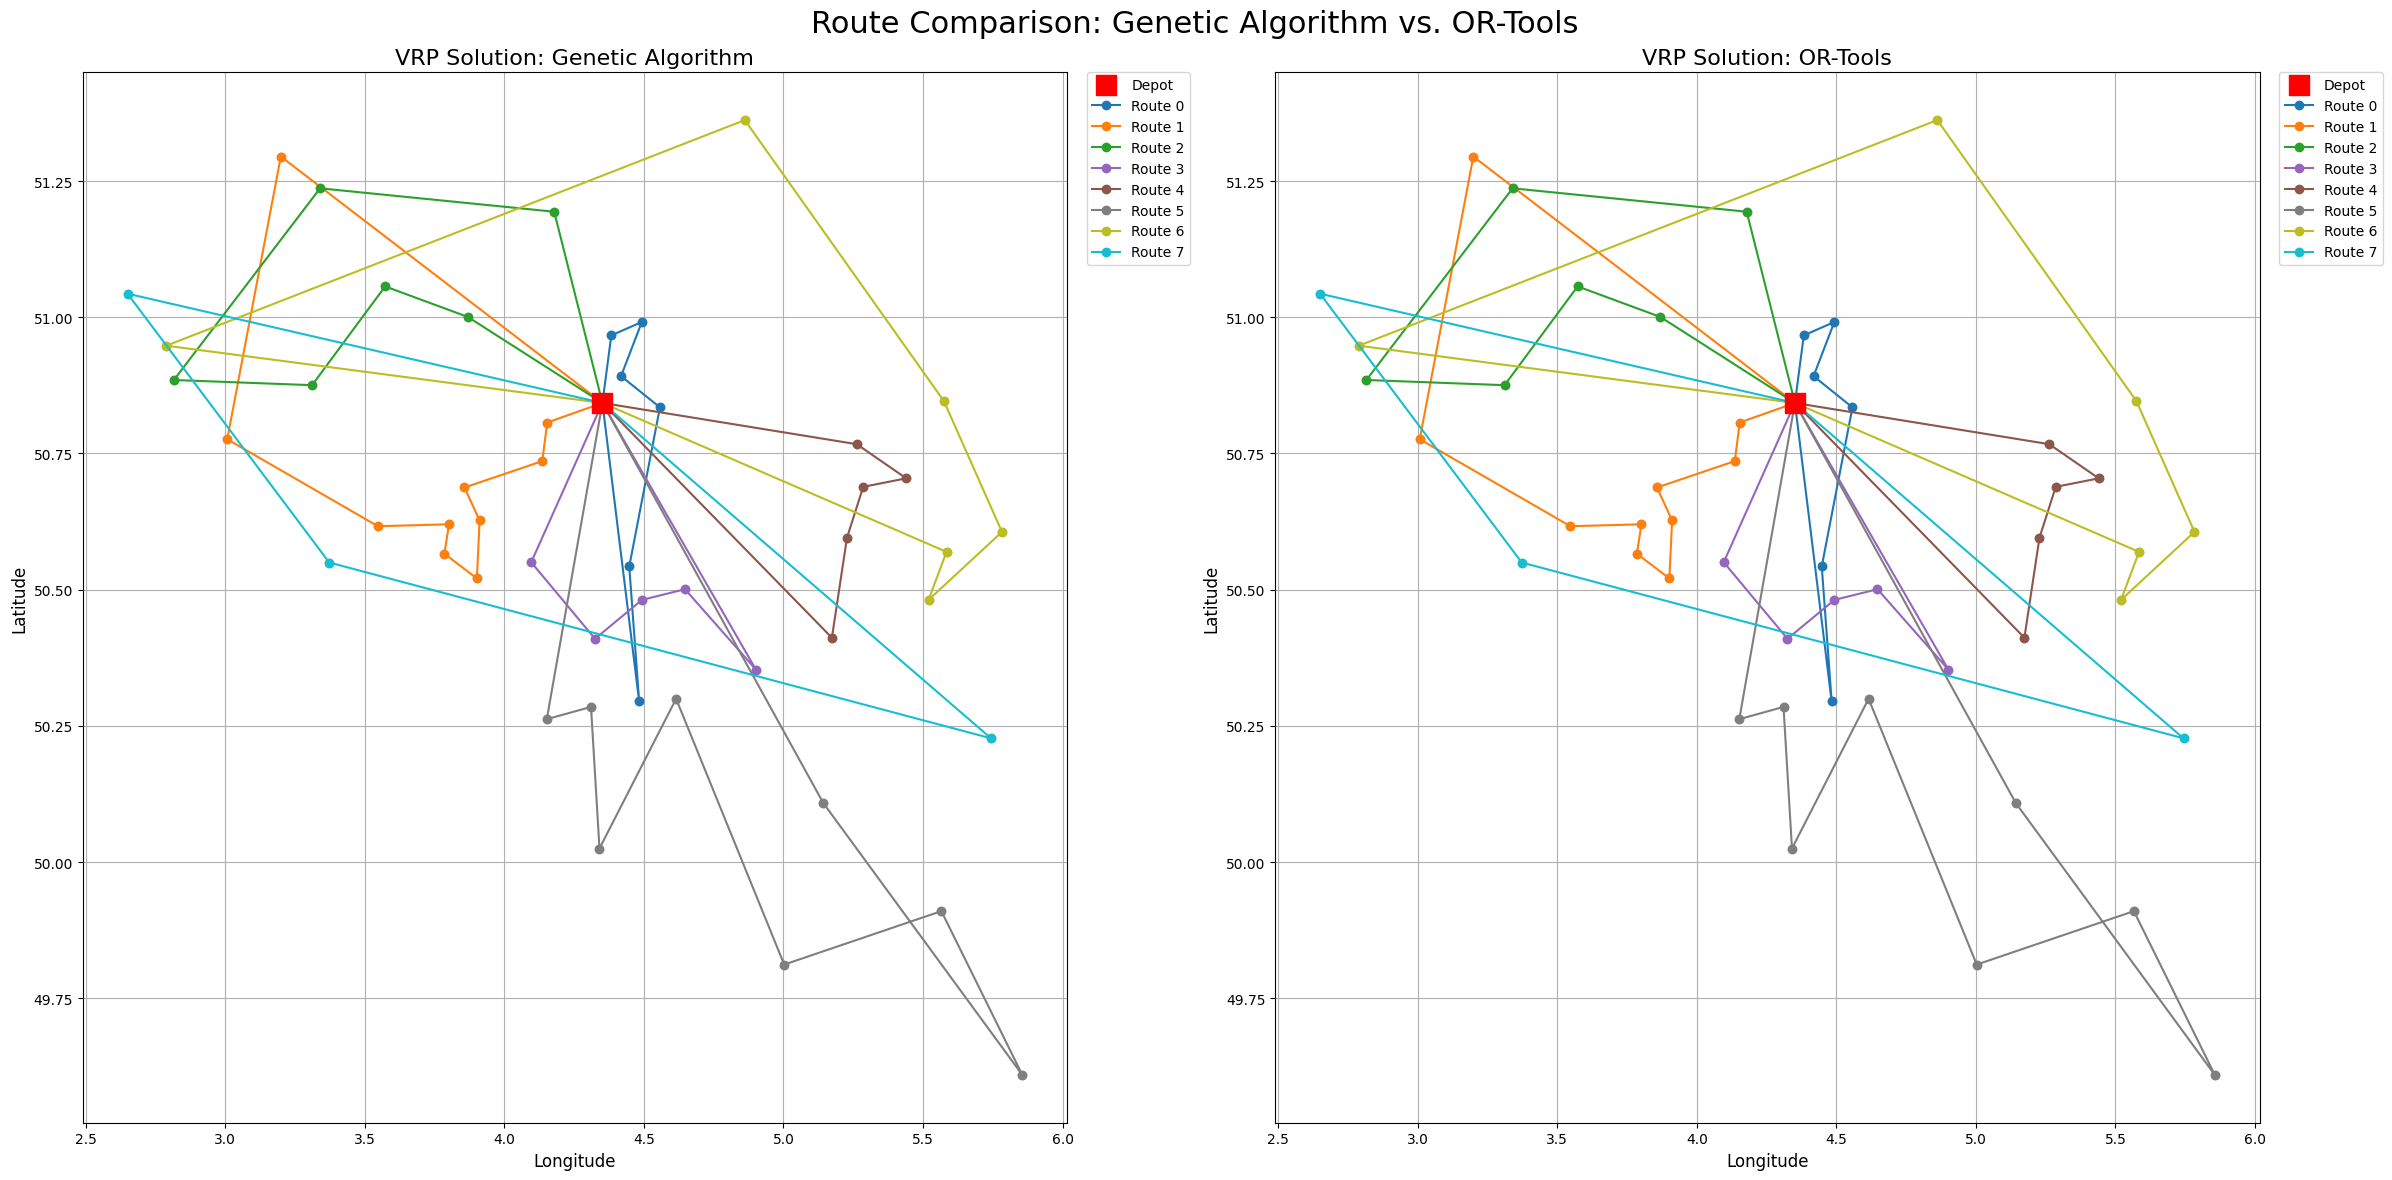

In [ ]:
import matplotlib.pyplot as plt
# Try importing colormaps directly from matplotlib
import matplotlib.cm as cm


def plot_routes_on_ax(ax, solutions, title, vrp_data, show_legend=True):
    """Plots the VRP routes for a given solution set on a specific matplotlib axis."""
    depot_idx = vrp_data['depot_index']
    depot_loc = vrp_data['locations'][depot_idx]

    # Plot all customer locations on the given axis
    customer_locs = np.array([loc for i, loc in enumerate(vrp_data['locations']) if i != depot_idx])
    # Removed the 'label' argument to exclude from legend
    ax.scatter(customer_locs[:, 1], customer_locs[:, 0], c='gray', alpha=0.5)

    # Plot depot on the given axis
    ax.scatter(depot_loc[1], depot_loc[0], c='red', marker='s', s=200, label='Depot', zorder=10)

    # Define a color map for the routes
    # Use the recommended way to get colormap
    colors = cm.get_cmap('tab10', len(solutions))

    for i, (cluster_id, solution) in enumerate(solutions.items()):
        route_indices = [int(idx) for idx in solution['route']]
        route = [depot_idx] + route_indices + [depot_idx]
        route_locs = np.array([vrp_data['locations'][j] for j in route])

        # Plot route lines on the given axis
        ax.plot(route_locs[:, 1], route_locs[:, 0], color=colors(i), marker='o', label=f'Route {cluster_id}')

    # Set titles and labels for the specific subplot
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.grid(True)

    if show_legend:
        # Place legend nicely
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

# --- Create the side-by-side plot ---
print("\n--- Generating Side-by-Side Visualization for GA and OR-Tools Routes ---")

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Plot GA solutions on the first axis (axes[0])
plot_routes_on_ax(axes[0], ga_solutions, "VRP Solution: Genetic Algorithm", vrp_data)

# Plot OR-Tools solutions on the second axis (axes[1])
plot_routes_on_ax(axes[1], ortools_solutions, "VRP Solution: OR-Tools", vrp_data)

# Adjust layout to prevent overlap and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
fig.suptitle("Route Comparison: Genetic Algorithm vs. OR-Tools", fontsize=22)
plt.show()

# Perbandingan


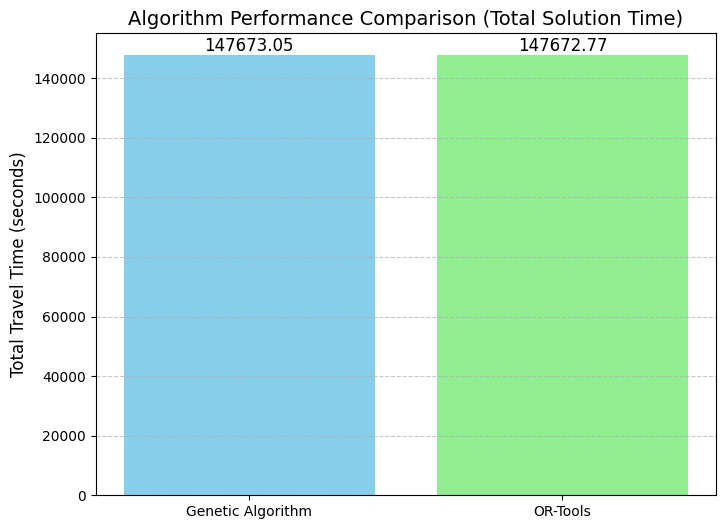

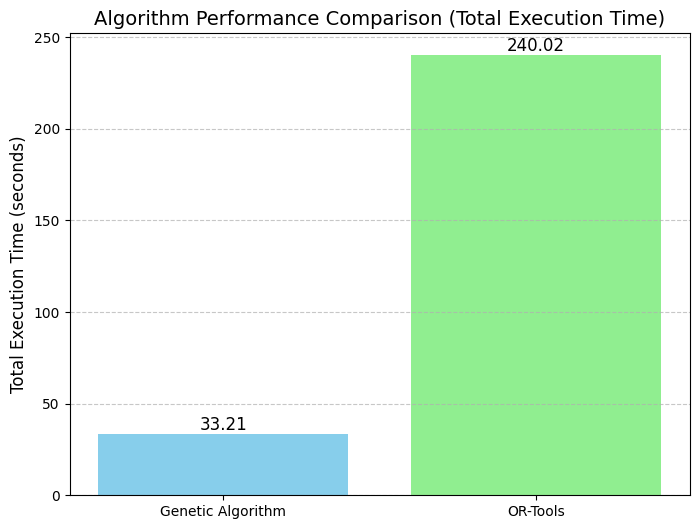


--- Detailed Comparison by Cluster (Solution Time) ---
 Cluster ID  Num Customers  GA Solution Time (s)  OR-Tools Solution Time (s)  Difference (s)  Difference (%)
          0              6              10898.83                    10898.79            0.04            0.00
          1             10              18929.83                    18929.78            0.05            0.00
          2              6              15887.74                    15887.72            0.02            0.00
          3              5              11206.16                    11206.13            0.03            0.00
          4              5              11531.81                    11531.77            0.04            0.00
          5              8              27534.58                    27534.53            0.05            0.00
          6              6              26924.91                    26924.88            0.03            0.00
          7              3              24759.19                    2475

In [ ]:
# --- COMPARISON BAR CHART (Solution Time) ---
algorithms = ['Genetic Algorithm', 'OR-Tools']
total_solution_times = [ga_total_cost, ortools_total_time] # Use ga_total_cost and ortools_total_time

plt.figure(figsize=(8, 6))
bars = plt.bar(algorithms, total_solution_times, color=['skyblue', 'lightgreen'])
plt.ylabel('Total Travel Time (seconds)', fontsize=12)
plt.title('Algorithm Performance Comparison (Total Solution Time)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=12)

plt.show()


# --- COMPARISON BAR CHART (Execution Time) ---
total_execution_times = [ga_total_time, ortools_total_execution_time] # Use recorded execution times

plt.figure(figsize=(8, 6))
bars = plt.bar(algorithms, total_execution_times, color=['skyblue', 'lightgreen'])
plt.ylabel('Total Execution Time (seconds)', fontsize=12)
plt.title('Algorithm Performance Comparison (Total Execution Time)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=12)

plt.show()


# --- DETAILED RESULTS DATAFRAME ---
results_data = []
for cid in sorted(clusters.keys()):
    ga_sol = ga_solutions.get(cid, {})
    or_sol = ortools_solutions.get(cid, {})

    ga_time = ga_sol.get('time', 0)
    or_time = or_sol.get('time', 0)

    diff_s = ga_time - or_time
    diff_percent = (diff_s / or_time) * 100 if or_time != 0 else 0

    results_data.append({
        'Cluster ID': cid,
        'Num Customers': len(clusters[cid]),
        'GA Solution Time (s)': ga_time,
        'OR-Tools Solution Time (s)': or_time,
        'Difference (s)': diff_s,
        'Difference (%)': diff_percent
    })

results_df = pd.DataFrame(results_data)

print("\n--- Detailed Comparison by Cluster (Solution Time) ---")
print(results_df.to_string(index=False, float_format="%.2f"))

# --- SUMMARY ---
total_diff_s = ga_total_cost - ortools_total_time
total_diff_percent = (total_diff_s / ortools_total_time) * 100 if ortools_total_time > 0 else 0

print(f"\nSummary:")
print(f"GA Total Solution Time: {ga_total_cost:.2f} seconds")
print(f"OR-Tools Total Solution Time: {ortools_total_time:.2f} seconds")
print(f"The Genetic Algorithm solution was {total_diff_s:.2f} seconds longer, which is {total_diff_percent:.2f}% less optimal than the OR-Tools solution (based on total solution time).")
print(f"\nGA Total Execution Time: {ga_total_time:.2f} seconds")
print(f"OR-Tools Total Execution Time: {ortools_total_execution_time:.2f} seconds")

# Enhanced Genetic Algorithm (OX1 Crossover, Inversion Mutation, Roulette Selection, Dynamic Penalty)

PARAMETER 1

In [ ]:
# def calculate_route_cost_dynamic_penalty(route, time_matrix, depot_index, demands, vehicle_capacity, current_generation, total_generations, base_penalty=1000):
#     """
#     Calculates the total travel cost (time) for a given route,
#     with a penalty for exceeding vehicle capacity that increases with generations.
#     """
#     if not route:
#         return 0

#     total_cost = 0
#     current_capacity = 0

#     # Cost from Depot to the first customer
#     total_cost += time_matrix[depot_index][route[0]]
#     current_capacity += demands[route[0]]

#     # Cost between consecutive customers
#     for i in range(len(route) - 1):
#         total_cost += time_matrix[route[i]][route[i+1]]
#         current_capacity += demands[route[i+1]]

#     # Calculate dynamic penalty factor
#     # Starts at base_penalty and increases up to base_penalty * 10 (or another factor) by the last generation
#     # You can adjust the growth function
#     penalty_factor = base_penalty * (1 + 9 * (current_generation / total_generations))
#     # Ensure penalty is at least the base
#     penalty_factor = max(base_penalty, penalty_factor)


#     # Check capacity constraint and apply dynamic penalty
#     if current_capacity > vehicle_capacity:
#         total_cost += (current_capacity - vehicle_capacity) * penalty_factor


#     # Cost from the last customer back to the Depot
#     total_cost += time_matrix[route[-1]][depot_index]

#     return total_cost

# # Using Ordered Crossover (OX1) for performance testing
# def ordered_crossover(p1, p2):
#     """
#     Ordered Crossover (OX1) for permutations.
#     """
#     size = len(p1)
#     child = [None] * size

#     # Select crossover points
#     start, end = sorted(random.sample(range(size), 2))

#     # Copy the segment from parent 1
#     child[start:end] = p1[start:end]

#     # Fill the rest of the child with elements from parent 2
#     # in the order they appear after 'end', wrapping around
#     p2_index = end
#     child_index = end
#     while None in child:
#         if p2[p2_index % size] not in child:
#             child[child_index % size] = p2[p2_index % size]
#             child_index += 1
#         p2_index += 1

#     return child


# def inversion_mutation(route):
#     """
#     Inversion Mutation: Reverses a segment of the route.
#     """
#     size = len(route)
#     if size < 2:
#         return route[:] # No mutation needed for size < 2

#     mutated_route = route[:]
#     # Select mutation points
#     mutation_points = sorted(random.sample(range(size), 2))
#     start, end = mutation_points[0], mutation_points[1]

#     # Reverse the segment
#     mutated_route[start:end+1] = mutated_route[start:end+1][::-1]

#     return mutated_route


# def roulette_wheel_selection(population, costs):
#     """
#     Roulette Wheel Selection based on inverse cost (lower cost is better).
#     Higher fitness corresponds to lower cost.
#     """
#     # Handle cases where all costs are the same or very large
#     min_cost = min(costs)
#     if min_cost <= 0: # Avoid division by zero or negative fitness
#         # Shift costs to make them positive, smaller is still better
#         shifted_costs = [c - min_cost + 1 for c in costs]
#     else:
#         shifted_costs = costs

#     # Calculate fitness (inverse of shifted cost)
#     fitness = [1.0 / c for c in shifted_costs]

#     # Calculate probabilities
#     total_fitness = sum(fitness)
#     if total_fitness == 0: # Avoid division by zero if all fitness are 0 (unlikely with shifted costs)
#         # Fallback to random selection if total fitness is 0
#         print("Warning: Total fitness is 0. Falling back to random selection.")
#         return random.choice(population)

#     probabilities = [f / total_fitness for f in fitness]

#     # Select an individual based on probabilities
#     selected_index = random.choices(range(len(population)), weights=probabilities, k=1)[0]

#     return population[selected_index]


# def run_enhanced_genetic_algorithm(customer_indices, vrp_data,
#                                    pop_size=200, generations=2000, mutation_rate=0.05,
#                                    crossover_rate=0.8, elitism_size=0.01): # Elitism as percentage
#     """
#     Solves the VRP for a single cluster using an Enhanced Genetic Algorithm
#     with OX1 Crossover, Inversion Mutation, Roulette Wheel Selection, Elitism, and Dynamic Penalty.
#     """
#     time_matrix = vrp_data['time_matrix']
#     depot_index = vrp_data['depot_index']
#     demands = vrp_data['demands']
#     vehicle_capacity = vrp_data['capacity']

#     # --- EDGE CASE HANDLING ---
#     # If there's only one customer, no optimization is needed. Return the simple route.
#     if len(customer_indices) <= 1:
#          cost = calculate_route_cost_dynamic_penalty(customer_indices, time_matrix, depot_index, demands, vehicle_capacity, 0, 1) # Use base penalty
#          return customer_indices, cost


#     # Calculate the number of elite individuals based on the percentage
#     num_elite = max(1, int(pop_size * elitism_size)) # Ensure at least 1 elite

#     # 1. Initialization: Create an initial population of random routes
#     population = [random.sample(customer_indices, len(customer_indices)) for _ in range(pop_size)]

#     best_overall_route = None
#     best_overall_cost = float('inf')

#     for gen in range(generations):
#         # 2. Fitness Evaluation: Calculate the cost for each route with dynamic penalty
#         costs = [calculate_route_cost_dynamic_penalty(
#                      ind, time_matrix, depot_index, demands, vehicle_capacity,
#                      gen, generations)
#                  for ind in population]

#         # Update best overall solution found so far
#         min_cost_current_gen = min(costs)
#         if min_cost_current_gen < best_overall_cost:
#             best_overall_cost = min_cost_current_gen
#             best_overall_route = population[np.argmin(costs)][:] # Store a copy

#         # 3. Elitism: Preserve the best individuals from the current generation
#         elite_indices = np.argsort(costs)[:num_elite]
#         elites = [population[i][:] for i in elite_indices] # Store copies

#         # 4. Selection (Roulette Wheel Selection)
#         num_offspring = pop_size - num_elite
#         selected = []
#         for _ in range(num_offspring):
#              selected.append(roulette_wheel_selection(population, costs))


#         # 5. Crossover and Mutation
#         offspring = []
#         # Ensure selected has an even number for pairwise crossover
#         # If odd, duplicate one parent to make it even for pairwise crossover
#         if len(selected) % 2 != 0:
#              selected.append(random.choice(selected))


#         for i in range(0, len(selected), 2):
#             p1 = selected[i]
#             p2 = selected[i+1]

#             if random.random() < crossover_rate and len(p1) > 1:
#                  # Use Ordered Crossover (OX1)
#                  child1 = ordered_crossover(p1, p2)
#                  child2 = ordered_crossover(p2, p1) # Create second child by swapping parents
#                  offspring.append(child1)
#                  offspring.append(child2)
#             else:
#                 # If no crossover, just copy parents
#                  offspring.append(p1[:])
#                  # Ensure we don't exceed num_offspring
#                  if len(offspring) < num_offspring:
#                       offspring.append(p2[:])


#         # Apply mutation to offspring
#         mutated_offspring = []
#         # Ensure we don't exceed num_offspring after crossover
#         offspring = offspring[:num_offspring]

#         for child in offspring:
#              if random.random() < mutation_rate and len(child) > 1: # Ensure child has more than 1 element for mutation
#                  mutated_offspring.append(inversion_mutation(child))
#              else:
#                  mutated_offspring.append(child[:]) # Store a copy


#         # 6. Create New Population: Combine elites with the new offspring
#         population = elites + mutated_offspring

#     # After all generations, the best solution found might be in the elites or final population
#     # Re-evaluate costs with final penalty factor to get true cost
#     final_penalty_cost = calculate_route_cost_dynamic_penalty(
#          best_overall_route, time_matrix, depot_index, demands, vehicle_capacity,
#          generations, generations) # Use final generation penalty

#     return best_overall_route, final_penalty_cost

# # --- SOLVE FOR EACH CLUSTER USING ENHANCED GA ---
# enhanced_ga_solutions = {}
# enhanced_ga_total_cost = 0

# print("\n--- Running Enhanced Genetic Algorithm (OX1 Crossover, Inversion Mutation, Roulette Selection, Dynamic Penalty) for each cluster ---")
# for cluster_id, customer_indices in sorted(clusters.items()):
#     if not customer_indices:
#         print(f"Cluster {cluster_id} is empty, skipping.")
#         continue

#     print(f"Solving for Cluster {cluster_id} ({len(customer_indices)} customers)...")
#     best_route, best_cost = run_enhanced_genetic_algorithm(
#         customer_indices,
#         vrp_data
#     )
#     enhanced_ga_solutions[cluster_id] = {'route': best_route, 'time': best_cost}
#     enhanced_ga_total_cost += best_cost
#     # Check if the best route is valid in terms of capacity for printing
#     route_demand = sum(vrp_data['demands'][c] for c in best_route)
#     valid_route = route_demand <= vrp_data['capacity']

#     print(f"  -> Best Route Cost: {best_cost:.2f} seconds (Valid: {valid_route})")


# print(f"\nEnhanced GA Total Solution Cost (Time): {enhanced_ga_total_cost:.2f} seconds")

PARAMETER 2

In [ ]:
# def calculate_route_cost_dynamic_penalty(route, time_matrix, depot_index, demands, vehicle_capacity, current_generation, total_generations, base_penalty=1000):
#     """
#     Calculates the total travel cost (time) for a given route,
#     with a penalty for exceeding vehicle capacity that increases with generations.
#     """
#     if not route:
#         return 0

#     total_cost = 0
#     current_capacity = 0

#     # Cost from Depot to the first customer
#     total_cost += time_matrix[depot_index][route[0]]
#     current_capacity += demands[route[0]]

#     # Cost between consecutive customers
#     for i in range(len(route) - 1):
#         total_cost += time_matrix[route[i]][route[i+1]]
#         current_capacity += demands[route[i+1]]

#     # Calculate dynamic penalty factor
#     # Starts at base_penalty and increases up to base_penalty * 10 (or another factor) by the last generation
#     # You can adjust the growth function
#     penalty_factor = base_penalty * (1 + 9 * (current_generation / total_generations))
#     # Ensure penalty is at least the base
#     penalty_factor = max(base_penalty, penalty_factor)


#     # Check capacity constraint and apply dynamic penalty
#     if current_capacity > vehicle_capacity:
#         total_cost += (current_capacity - vehicle_capacity) * penalty_factor


#     # Cost from the last customer back to the Depot
#     total_cost += time_matrix[route[-1]][depot_index]

#     return total_cost

# # Using Ordered Crossover (OX1) for performance testing
# def ordered_crossover(p1, p2):
#     """
#     Ordered Crossover (OX1) for permutations.
#     """
#     size = len(p1)
#     child = [None] * size

#     # Select crossover points
#     start, end = sorted(random.sample(range(size), 2))

#     # Copy the segment from parent 1
#     child[start:end] = p1[start:end]

#     # Fill the rest of the child with elements from parent 2
#     # in the order they appear after 'end', wrapping around
#     p2_index = end
#     child_index = end
#     while None in child:
#         if p2[p2_index % size] not in child:
#             child[child_index % size] = p2[p2_index % size]
#             child_index += 1
#         p2_index += 1

#     return child


# def inversion_mutation(route):
#     """
#     Inversion Mutation: Reverses a segment of the route.
#     """
#     size = len(route)
#     if size < 2:
#         return route[:] # No mutation needed for size < 2

#     mutated_route = route[:]
#     # Select mutation points
#     mutation_points = sorted(random.sample(range(size), 2))
#     start, end = mutation_points[0], mutation_points[1]

#     # Reverse the segment
#     mutated_route[start:end+1] = mutated_route[start:end+1][::-1]

#     return mutated_route


# def roulette_wheel_selection(population, costs):
#     """
#     Roulette Wheel Selection based on inverse cost (lower cost is better).
#     Higher fitness corresponds to lower cost.
#     """
#     # Handle cases where all costs are the same or very large
#     min_cost = min(costs)
#     if min_cost <= 0: # Avoid division by zero or negative fitness
#         # Shift costs to make them positive, smaller is still better
#         shifted_costs = [c - min_cost + 1 for c in costs]
#     else:
#         shifted_costs = costs

#     # Calculate fitness (inverse of shifted cost)
#     fitness = [1.0 / c for c in shifted_costs]

#     # Calculate probabilities
#     total_fitness = sum(fitness)
#     if total_fitness == 0: # Avoid division by zero if all fitness are 0 (unlikely with shifted costs)
#         # Fallback to random selection if total fitness is 0
#         print("Warning: Total fitness is 0. Falling back to random selection.")
#         return random.choice(population)

#     probabilities = [f / total_fitness for f in fitness]

#     # Select an individual based on probabilities
#     selected_index = random.choices(range(len(population)), weights=probabilities, k=1)[0]

#     return population[selected_index]


# def run_enhanced_genetic_algorithm(customer_indices, vrp_data,
#                                    pop_size=200, generations=2000, mutation_rate=0.2,
#                                    crossover_rate=0.8, elitism_size=0.1): # Elitism as percentage
#     """
#     Solves the VRP for a single cluster using an Enhanced Genetic Algorithm
#     with OX1 Crossover, Inversion Mutation, Roulette Wheel Selection, Elitism, and Dynamic Penalty.
#     """
#     time_matrix = vrp_data['time_matrix']
#     depot_index = vrp_data['depot_index']
#     demands = vrp_data['demands']
#     vehicle_capacity = vrp_data['capacity']

#     # --- EDGE CASE HANDLING ---
#     # If there's only one customer, no optimization is needed. Return the simple route.
#     if len(customer_indices) <= 1:
#          cost = calculate_route_cost_dynamic_penalty(customer_indices, time_matrix, depot_index, demands, vehicle_capacity, 0, 1) # Use base penalty
#          return customer_indices, cost


#     # Calculate the number of elite individuals based on the percentage
#     num_elite = max(1, int(pop_size * elitism_size)) # Ensure at least 1 elite

#     # 1. Initialization: Create an initial population of random routes
#     population = [random.sample(customer_indices, len(customer_indices)) for _ in range(pop_size)]

#     best_overall_route = None
#     best_overall_cost = float('inf')

#     for gen in range(generations):
#         # 2. Fitness Evaluation: Calculate the cost for each route with dynamic penalty
#         costs = [calculate_route_cost_dynamic_penalty(
#                      ind, time_matrix, depot_index, demands, vehicle_capacity,
#                      gen, generations)
#                  for ind in population]

#         # Update best overall solution found so far
#         min_cost_current_gen = min(costs)
#         if min_cost_current_gen < best_overall_cost:
#             best_overall_cost = min_cost_current_gen
#             best_overall_route = population[np.argmin(costs)][:] # Store a copy

#         # 3. Elitism: Preserve the best individuals from the current generation
#         elite_indices = np.argsort(costs)[:num_elite]
#         elites = [population[i][:] for i in elite_indices] # Store copies

#         # 4. Selection (Roulette Wheel Selection)
#         num_offspring = pop_size - num_elite
#         selected = []
#         for _ in range(num_offspring):
#              selected.append(roulette_wheel_selection(population, costs))


#         # 5. Crossover and Mutation
#         offspring = []
#         # Ensure selected has an even number for pairwise crossover
#         # If odd, duplicate one parent to make it even for pairwise crossover
#         if len(selected) % 2 != 0:
#              selected.append(random.choice(selected))


#         for i in range(0, len(selected), 2):
#             p1 = selected[i]
#             p2 = selected[i+1]

#             if random.random() < crossover_rate and len(p1) > 1:
#                  # Use Ordered Crossover (OX1)
#                  child1 = ordered_crossover(p1, p2)
#                  child2 = ordered_crossover(p2, p1) # Create second child by swapping parents
#                  offspring.append(child1)
#                  offspring.append(child2)
#             else:
#                 # If no crossover, just copy parents
#                  offspring.append(p1[:])
#                  # Ensure we don't exceed num_offspring
#                  if len(offspring) < num_offspring:
#                       offspring.append(p2[:])


#         # Apply mutation to offspring
#         mutated_offspring = []
#         # Ensure we don't exceed num_offspring after crossover
#         offspring = offspring[:num_offspring]

#         for child in offspring:
#              if random.random() < mutation_rate and len(child) > 1: # Ensure child has more than 1 element for mutation
#                  mutated_offspring.append(inversion_mutation(child))
#              else:
#                  mutated_offspring.append(child[:]) # Store a copy


#         # 6. Create New Population: Combine elites with the new offspring
#         population = elites + mutated_offspring

#     # After all generations, the best solution found might be in the elites or final population
#     # Re-evaluate costs with final penalty factor to get true cost
#     final_penalty_cost = calculate_route_cost_dynamic_penalty(
#          best_overall_route, time_matrix, depot_index, demands, vehicle_capacity,
#          generations, generations) # Use final generation penalty

#     return best_overall_route, final_penalty_cost

# # --- SOLVE FOR EACH CLUSTER USING ENHANCED GA ---
# enhanced_ga_solutions = {}
# enhanced_ga_total_cost = 0

# print("\n--- Running Enhanced Genetic Algorithm (OX1 Crossover, Inversion Mutation, Roulette Selection, Dynamic Penalty) for each cluster ---")
# for cluster_id, customer_indices in sorted(clusters.items()):
#     if not customer_indices:
#         print(f"Cluster {cluster_id} is empty, skipping.")
#         continue

#     print(f"Solving for Cluster {cluster_id} ({len(customer_indices)} customers)...")
#     best_route, best_cost = run_enhanced_genetic_algorithm(
#         customer_indices,
#         vrp_data
#     )
#     enhanced_ga_solutions[cluster_id] = {'route': best_route, 'time': best_cost}
#     enhanced_ga_total_cost += best_cost
#     # Check if the best route is valid in terms of capacity for printing
#     route_demand = sum(vrp_data['demands'][c] for c in best_route)
#     valid_route = route_demand <= vrp_data['capacity']

#     print(f"  -> Best Route Cost: {best_cost:.2f} seconds (Valid: {valid_route})")


# print(f"\nEnhanced GA Total Solution Cost (Time): {enhanced_ga_total_cost:.2f} seconds")

# Import Dataset dan Preprocessing (Updated to ensure node_id_mapping is available)

In [ ]:
def read_vrp_file(filename):

    with open(filename, 'r') as file:
        lines = file.readlines()

    data = {
        'name': '',
        'type': '',
        'dimension': 0,
        'edge_weight_type': '',
        'edge_weight_format': '',
        'edge_weight_unit': '',
        'capacity': 0,
        'node_coords_by_original_id': {},
        'demands_by_original_id': {},
        'depot_original_id': None,
        'time_matrix': [],
        'node_id_mapping': {},
        'node_names_by_original_id': {} # Add dictionary to store node names
    }

    current_section = None
    node_id_mapping = {}
    next_mapped_id = 0
    temp_edge_weights_lines = []

    for line in lines:
        line = line.strip()
        if not line:
            continue

        if line.startswith("NAME:"):
            data['name'] = line.split(":")[1].strip()
        elif line.startswith("TYPE:"):
            data['type'] = line.split(":")[1].strip()
        elif line.startswith("DIMENSION:"):
            data['dimension'] = int(line.split(":")[1].strip())
        elif line.startswith("EDGE_WEIGHT_TYPE:"):
            data['edge_weight_type'] = line.split(":")[1].strip()
        elif line.startswith("EDGE_WEIGHT_FORMAT:"):
            data['edge_weight_format'] = line.split(":")[1].strip()
        elif line.startswith("EDGE_WEIGHT_UNIT_OF_MEASUREMENT:"):
            data['edge_weight_unit'] = line.split(":")[1].strip()
        elif line.startswith("CAPACITY:"):
            data['capacity'] = int(line.split(":")[1].strip())

        elif "NODE_COORD_SECTION" in line:
            current_section = "NODE_COORD_SECTION"
            continue
        elif "DEMAND_SECTION" in line:
            current_section = "DEMAND_SECTION"
            continue
        elif "DEPOT_SECTION" in line:
            current_section = "DEPOT_SECTION"
            continue
        elif "EDGE_WEIGHT_SECTION" in line:
            current_section = "EDGE_WEIGHT_SECTION"
            continue
        elif "EOF" in line:
            break

        if current_section == "NODE_COORD_SECTION":
            parts = line.split()
            # Check if there are at least 4 parts (ID, Lat, Lon, Name)
            if len(parts) >= 4:
                try:
                    original_id = int(float(parts[0]))
                    lat = float(parts[1])
                    lon = float(parts[2])
                    name = parts[3] # Extract the name from the last column
                    data['node_coords_by_original_id'][original_id] = (lat, lon)
                    data['node_names_by_original_id'][original_id] = name # Store the name
                    node_id_mapping[original_id] = next_mapped_id
                    next_mapped_id += 1
                except ValueError:
                    print(f"Format error (NODE_COORD_SECTION): {line}")
            elif len(parts) >= 3: # Handle cases where name might be missing (less common in this file)
                 try:
                    original_id = int(float(parts[0]))
                    lat = float(parts[1])
                    lon = float(parts[2])
                    data['node_coords_by_original_id'][original_id] = (lat, lon)
                    data['node_names_by_original_id'][original_id] = f"Node_{original_id}" # Assign a default name
                    node_id_mapping[original_id] = next_mapped_id
                    next_mapped_id += 1
                 except ValueError:
                    print(f"Format error (NODE_COORD_SECTION): {line}")


        elif current_section == "DEMAND_SECTION":
            parts = line.split()
            if len(parts) >= 2:
                try:
                    original_id = int(float(parts[0]))
                    demand = int(float(parts[1]))
                    data['demands_by_original_id'][original_id] = demand
                except ValueError:
                    print(f"Format error (DEMAND_SECTION): {line}")

        elif current_section == "DEPOT_SECTION":
            try:
                original_id = int(float(line.split()[0]))
                if original_id == -1:
                    current_section = None
                else:
                    data['depot_original_id'] = original_id
            except ValueError:
                print(f"Format error (DEPOT_SECTION): {line}")

        elif current_section == "EDGE_WEIGHT_SECTION":
            temp_edge_weights_lines.append(line)

    dimension = data['dimension']
    data['time_matrix'] = np.zeros((dimension, dimension))

    full_matrix_string = " ".join(temp_edge_weights_lines)
    all_weights = [float(w) for w in full_matrix_string.split()]

    k = 0
    for i in range(dimension):
        for j in range(dimension):
            data['time_matrix'][i, j] = all_weights[k]
            k += 1
            if k >= len(all_weights):
                break
        if k >= len(all_weights):
            break

    mapped_locations = [None] * dimension
    mapped_demands = [0] * dimension
    mapped_names = [None] * dimension # Add list for mapped names

    # Sort original IDs based on their assigned mapped ID
    sorted_original_ids = sorted(node_id_mapping.keys(), key=lambda x: node_id_mapping[x])

    for original_id in sorted_original_ids:
        mapped_id = node_id_mapping[original_id]
        mapped_locations[mapped_id] = data['node_coords_by_original_id'][original_id]
        mapped_demands[mapped_id] = data['demands_by_original_id'].get(original_id, 0)
        mapped_names[mapped_id] = data['node_names_by_original_id'].get(original_id, f"Node_{original_id}") # Get name or assign default


    data['locations'] = mapped_locations
    data['demands'] = mapped_demands
    data['depot_index'] = node_id_mapping.get(data['depot_original_id'])
    data['node_id_mapping'] = node_id_mapping # Add the mapping to the returned data
    data['mapped_node_names'] = mapped_names # Add mapped names to data

    return data

# --- Call the function to load data ---
file_path = "belgium-road-time-n50-k10.vrp"
vrp_data = read_vrp_file(file_path)

print(f"Nama Dataset: {vrp_data['name']}")
print(f"Tipe Masalah: {vrp_data['type']}")
print(f"Total Dimensi (Node): {vrp_data['dimension']}")
print(f"Kapasitas Kendaraan: {vrp_data['capacity']}")
print(f"Unit Bobot Edge: {vrp_data['edge_weight_unit']}")
print(f"Indeks Depot (terpetakan): {vrp_data['depot_index']}")
print(f"Koordinat Depot: {vrp_data['locations'][vrp_data['depot_index']]}")
print(f"Nama Depot (terpetakan): {vrp_data['mapped_node_names'][vrp_data['depot_index']]}")


# Example access to check if mapping works
# Find an original ID and its mapped index (excluding depot)
example_original_id = None
for original_id, mapped_id in vrp_data['node_id_mapping'].items():
    if original_id != vrp_data['depot_original_id']:
        example_original_id = original_id
        break

if example_original_id is not None:
    example_mapped_index = vrp_data['node_id_mapping'][example_original_id]
    print(f"\nExample: Original ID {example_original_id} maps to Mapped Index {example_mapped_index}")
    print(f"Name Pelanggan Original ID {example_original_id}: {vrp_data['node_names_by_original_id'][example_original_id]}")
    print(f"Name Pelanggan Mapped Index {example_mapped_index}: {vrp_data['mapped_node_names'][example_mapped_index]}")
    print(f"Demand Pelanggan Original ID {example_original_id}: {vrp_data['demands_by_original_id'][example_original_id]}")
    print(f"Demand Pelanggan Mapped Index {example_mapped_index}: {vrp_data['demands'][example_mapped_index]}")


    # Check time matrix access using mapped indices
    if vrp_data['depot_index'] is not None:
         print(f"Waktu tempuh dari Depot ({vrp_data['mapped_node_names'][vrp_data['depot_index']]}, idx {vrp_data['depot_index']}) ke pelanggan ({vrp_data['mapped_node_names'][example_mapped_index]}, idx {example_mapped_index}): {vrp_data['time_matrix'][vrp_data['depot_index']][example_mapped_index]:.3f} detik")

print("\nSebagian Matriks Waktu (5x5 pertama):")
print(vrp_data['time_matrix'][:5, :5])

Nama Dataset: belgium-road-time-n50-k10
Tipe Masalah: CVRP
Total Dimensi (Node): 50
Kapasitas Kendaraan: 125
Unit Bobot Edge: sec
Indeks Depot (terpetakan): 0
Koordinat Depot: (50.8427501, 4.3515499)
Nama Depot (terpetakan): BRUSSEL

Example: Original ID 55 maps to Mapped Index 1
Name Pelanggan Original ID 55: ANTHISNES
Name Pelanggan Mapped Index 1: ANTHISNES
Demand Pelanggan Original ID 55: 15
Demand Pelanggan Mapped Index 1: 15
Waktu tempuh dari Depot (BRUSSEL, idx 0) ke pelanggan (ANTHISNES, idx 1): 5194.095 detik

Sebagian Matriks Waktu (5x5 pertama):
[[   0.    5194.095 4508.267 3686.259 3860.893]
 [5090.662    0.    3481.919 8228.263 6269.092]
 [4446.509 3475.836    0.    7711.021 4706.544]
 [3673.741 8356.473 7774.428    0.    5146.348]
 [3833.977 6228.651 4711.105 5108.773    0.   ]]


# Detail Rute (Location dan Demand)

In [ ]:
# Helper function to get original ID and demand
def get_customer_info(mapped_index, vrp_data):
    # Use mapped_node_names to get the name
    name = vrp_data['mapped_node_names'][mapped_index]
    demand = vrp_data['demands'][mapped_index]
    return name, demand # Return name instead of original ID

print("\n--- Genetic Algorithm Route Details ---")
depot_index = vrp_data['depot_index']
# Use mapped_node_names to get the depot name
depot_name = vrp_data['mapped_node_names'][depot_index]


for cluster_id, solution in sorted(ga_solutions.items()):
    route = solution['route']
    cost = solution['time']
    route_demand = sum(vrp_data['demands'][c] for c in route)
    valid_route = route_demand <= vrp_data['capacity']

    print(f"\nRoute for Group {cluster_id}: (Total Cost: {cost:.2f} seconds, Total Demand: {route_demand}, Valid: {valid_route})")

    # Construct the full route including depot at start and end
    full_route_mapped_indices = [depot_index] + route + [depot_index]

    # Format the route display (Depot -> Customer1(demand) -> Customer2(demand) -> ... -> Depot)
    route_display = []
    for i, mapped_idx in enumerate(full_route_mapped_indices):
        if mapped_idx == depot_index:
            display_str = f"Depot ({depot_name})"
        else:
            name, demand = get_customer_info(mapped_idx, vrp_data)
            display_str = f"{name} (Demand: {demand})" # Use name here
        route_display.append(display_str)

    print("  -> ".join(route_display))


print("\n--- OR-Tools Route Details ---")
for cluster_id, solution in sorted(ortools_solutions.items()):
    route = solution['route']
    cost = solution['time']
    route_demand = sum(vrp_data['demands'][c] for c in route)
    valid_route = route_demand <= vrp_data['capacity']

    print(f"\nRoute for Group {cluster_id}: (Total Cost: {cost:.2f} seconds, Total Demand: {route_demand}, Valid: {valid_route})")

    # Construct the full route including depot at start and end
    full_route_mapped_indices = [depot_index] + route + [depot_index]

    # Format the route display (Depot -> Customer1(demand) -> Customer2(demand) -> ... -> Depot)
    route_display = []
    for i, mapped_idx in enumerate(full_route_mapped_indices):
        if mapped_idx == depot_index:
            display_str = f"Depot ({depot_name})"
        else:
            name, demand = get_customer_info(mapped_idx, vrp_data)
            display_str = f"{name} (Demand: {demand})" # Use name here
        route_display.append(display_str)

    print("  -> ".join(route_display))


--- Genetic Algorithm Route Details ---

Route for Group 0: (Total Cost: 10898.83 seconds, Total Demand: 125, Valid: True)
Depot (BRUSSEL)  -> SOMZEE (Demand: 20)  -> LES_BONS_VILLERS (Demand: 10)  -> VOSSEM (Demand: 19)  -> HAREN_BRUSSEL (Demand: 33)  -> HOFSTADE_BT. (Demand: 25)  -> HUMBEEK (Demand: 18)  -> Depot (BRUSSEL)

Route for Group 1: (Total Cost: 18929.83 seconds, Total Demand: 125, Valid: True)
Depot (BRUSSEL)  -> SINT-KWINTENS-LENNIK (Demand: 17)  -> PEPINGEN (Demand: 4)  -> OLLIGNIES (Demand: 5)  -> GONDREGNIES (Demand: 14)  -> JURBISE (Demand: 26)  -> CHIEVRES (Demand: 17)  -> MAFFLE (Demand: 28)  -> MAULDE (Demand: 9)  -> KOMEN (Demand: 2)  -> LISSEWEGE (Demand: 3)  -> Depot (BRUSSEL)

Route for Group 2: (Total Cost: 15887.74 seconds, Total Demand: 124, Valid: True)
Depot (BRUSSEL)  -> WETTEREN (Demand: 16)  -> LANDEGEM (Demand: 25)  -> BAVIKHOVE (Demand: 31)  -> ELVERDINGE (Demand: 18)  -> DAMME (Demand: 33)  -> NIEUWKERKEN-WAAS (Demand: 1)  -> Depot (BRUSSEL)

Route 